# Exploration of Sales Data

Snohomish County Parcel Search:  
https://www.snoco.org/proptax/search.aspx?parcel_number= ***PARCELHERE***


In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import scipy.stats as stats

### Data from Mongo Database

In [2]:
from pymongo import MongoClient
client = MongoClient('localhost', 27017)

In [3]:
db = client['homesales_snohomish']
sales = db.homesales

In [4]:
rows = sales.find()
home_sales = pd.DataFrame(list(rows))
home_sales = home_sales.drop('_id', axis=1)

In [5]:
len(home_sales['Parcel #'].unique())

2090

### Data from csv

In [6]:
# home_sales1 = pd.read_csv(
#     'data/sales.csv',
#     index_col=0,
#     dtype={
#         'Parcel #': str,
#         'Year Built': str,
#         'Type': str,
#         'Quality/Grade': str,
#         'Address': str,
#         'City': str,
#         'Nbhd': str
#     }
# )

## Initial inspection

In [7]:
home_sales.head()

,Parcel #,Date of Sale,Sale Price,Lot Size,Year Built,Type,Quality/Grade,Sqft,Address,City,Nbhd,Use Code
0,31051100400500,1/31/2020 12:00:00 AM,"$2,500,000.00",5.44,,,,,21015 STATE ROUTE 9 NE,Arlington,Nbhd:5203000,521
1,00804500000100,1/31/2020 12:00:00 AM,"$416,000.00",0.29,1993,Tri Level,Avg,1430,20911 66TH AVE NE,Arlington,Nbhd:2408000,111
2,00960009607300,1/31/2020 12:00:00 AM,"$75,000.00",0,1996,Dbl Wide,V Good,1620,20227 80TH AVE NE SPC 73,Arlington,Nbhd:2408906,119
3,00874800005200,1/29/2020 12:00:00 AM,"$419,000.00",0.14,2001,1 1/2 Sty,Avg,1813,18127 GREYWALLS DR,Arlington,Nbhd:2408000,111
4,00946600000300,1/29/2020 12:00:00 AM,"$347,000.00",0.1166,2003,1 Sty,Avg-,1348,18722 35TH AVE NE,,Nbhd:2408000,111


In [8]:
home_sales.shape

(2248, 12)

In [9]:
len(home_sales['Parcel #'].unique())

2090

## Data Cleaning

#### Dates 

In [10]:
# ********** Clean Dates ***************
datetime.datetime.strptime(
    home_sales['Date of Sale'][0], '%m/%d/%Y %H:%M:%S %p')

datetime.datetime(2020, 1, 31, 12, 0)

In [11]:
def date_clean(d):
    return datetime.datetime.strptime(d, '%m/%d/%Y %H:%M:%S %p')

In [12]:
home_sales['Date of Sale'] = home_sales['Date of Sale'].map(date_clean)

#### Price

In [13]:
# ********** Clean Sale Price **********
def sale_price_clean(price):
    return float(price.strip('$').replace(',',''))

In [14]:
sale_price_clean(home_sales['Sale Price'][0])

2500000.0

In [15]:
home_sales['Sale Price'] = home_sales['Sale Price'].map(sale_price_clean)

#### Use Code, Sqft, Lot Size, 

In [16]:
home_sales['Use Code'] = home_sales['Use Code'].map(int)

In [31]:
def sqft_clean(sqft):
    if sqft:
        return int(sqft)
    else:
        return None

In [32]:
home_sales['Sqft'] = home_sales['Sqft'].map(sqft_clean)

In [59]:
home_sales['Lot Size'] = home_sales['Lot Size'].map(float)

In [67]:
def year_built_clean(year):
    if year:
        return int(year)
    else:
        return None

In [69]:
home_sales['Year Built'] = home_sales['Year Built'].map(year_built_clean)

#### Neighborhood

In [19]:
home_sales['Nbhd'][0].split(':')[1]

'5203000'

In [20]:
home_sales['Nbhd'] = home_sales['Nbhd'].map(lambda n: n.split(':')[1])

In [21]:
np.sort(home_sales['Use Code'].unique())

array([110, 111, 112, 116, 117, 118, 119, 121, 122, 123, 124, 130, 131,
       136, 141, 142, 143, 145, 160, 179, 183, 184, 185, 186, 188, 198,
       249, 344, 349, 431, 461, 502, 511, 519, 521, 539, 553, 559, 581,
       591, 599, 615, 623, 629, 637, 639, 641, 651, 661, 691, 699, 723,
       744, 830, 860, 880, 910, 911, 912, 913, 914, 940, 941, 950])

In [22]:
# home_sales[home_sales['Use Code']==118].iloc[0];

In [23]:
use_codes = {
    110: 'SFR - Senior Citizen Exemption Residual',
    111: 'SFR - Detached (One Structure)',
    112: 'SFR - Detached (Two Structures)',
    116: 'Common Wall Single Family Residences',
    117: 'Manufactured Home / Leased Site',
    118: 'Manufactured Home / Owned Site',
    119: 'Manufactured Home / Mobile Home Park',
    122: 'Two Family Residence (Duplex)',
    123: 'Three Family Residence (Tri-Plex)',
    124: 'Four Family Residence (Four Plex)',
    130: 'MFR 5-7 Units',
    131: 'MFR 8-11 Units',
    136: 'MFR 51-100 Units',
    141: 'SFR / Condominium - Detached',
    142: 'SFR / Condominium – Common Wall',
    143: 'SFR / Condominium – Multi Family',
    145: 'SFR / Condominium – Converted from Apartments',
    179: 'Other Group Quarters',
    183: 'Non Residential Structure',
    185: 'Well',
    186: 'Septic System & Well',
    188: 'SFR Converted or Group Home',
    198: 'Vacation Cabins',
    344: 'Transportation Equipment',
    349: 'Other Fabricated Metal Products NEC',
    521: 'Lumber & Other Building Materials',
    641: 'Automobile Repair & Services',
    910: 'Undeveloped (Vacant) Land',
    913: 'Recreational Lot',
    940: 'Open Space General',
    941: 'Open Space General Agriculture Conservation'  
}

In [189]:
home_sales.groupby('Use Code')['Use Code'].count()

Use Code
110      4
111    678
112     12
116     22
117      4
118     35
119     36
122      9
123      1
124      3
130      1
131      2
136      1
141     37
142     13
143    100
145     21
179      1
183      2
185      1
186      2
188      1
198      1
344      1
349      1
502      1
519      1
521      1
539      2
581      2
599      3
629      1
637      1
639      3
641      3
651      1
691      1
699      1
744      1
830      2
860      1
910    203
911      2
912      1
914     22
940      2
Name: Use Code, dtype: int64

In [24]:
sfr_codes = [111,112,113,116,118,141,142]

In [25]:
type(home_sales['Use Code'][0])

numpy.int64

In [70]:
single_family = home_sales[home_sales['Use Code'].isin(sfr_codes)].copy()

In [71]:
single_family.head(3)

,Parcel #,Date of Sale,Sale Price,Lot Size,Year Built,Type,Quality/Grade,Sqft,Address,City,Nbhd,Use Code
1,00804500000100,2020-01-31 12:00:00,416000.0,0.2900,1993.0,Tri Level,Avg,1430.0,20911 66TH AVE NE,Arlington,2408000,111
3,00874800005200,2020-01-29 12:00:00,419000.0,0.1400,2001.0,1 1/2 Sty,Avg,1813.0,18127 GREYWALLS DR,Arlington,2408000,111
4,00946600000300,2020-01-29 12:00:00,347000.0,0.1166,2003.0,1 Sty,Avg-,1348.0,18722 35TH AVE NE,,2408000,111


In [35]:
home_sales['City'].unique()

array(['Arlington', '', 'Bothell', 'Brier', 'Darrington', 'Edmonds',
       'Everett', 'Lynnwood', 'Goldbar', 'Granite Falls', 'Lake Stevens',
       'Marysville', 'Stanwood', 'Mill Creek', 'Monroe',
       'Mountlake Terrace', 'MUKILTEO', 'Snohomish', 'Sultan', 'Woodway',
       'BOT        Bothell'], dtype=object)

## Exploration

In [36]:
single_family['price/sqft'] = single_family['Sale Price']/single_family['Sqft']

In [37]:
single_family.groupby('Use Code').mean()

,Sale Price,Sqft,price/sqft
Use Code,,,
111,542193.833059,2044.532949,280.826318
112,587682.777778,1688.222222,462.534616
116,476194.125000,1890.450000,255.857618
118,321269.967213,1454.116667,224.764762
141,492992.256098,1932.195122,257.347414
142,403765.517241,1583.172414,258.212210


In [38]:
fonts = {'fontsize':16, 'fontfamily':'serif'}

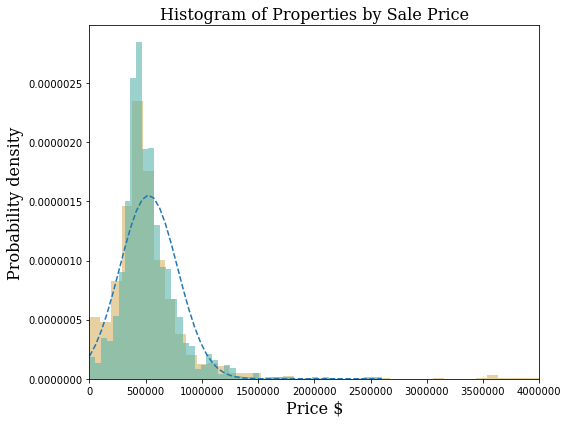

In [53]:
fig, ax = plt.subplots(figsize=(8,6))

mu = single_family['Sale Price'].mean()
std = single_family['Sale Price'].std()

ax.hist(home_sales['Sale Price'], bins=100, density=True, alpha=.6, color='#d8b365')
n, bins, patches = ax.hist(single_family['Sale Price'], bins=50,density=True, color='#5ab4ac', alpha=.6)
fit = stats.norm(loc=mu, scale=std).pdf(bins)
ax.plot(bins,fit,'--')
ax.set_xlim(0,4000000)
ax.set_xlabel('Price $', **fonts)
ax.set_ylabel('Probability density', **fonts)
ax.set_title('Histogram of Properties by Sale Price', **fonts)
ax.ticklabel_format(style='plain')
fig.tight_layout()
plt.show()

In [40]:
mean_per_day = single_family.groupby('Date of Sale')['Sale Price'].mean()

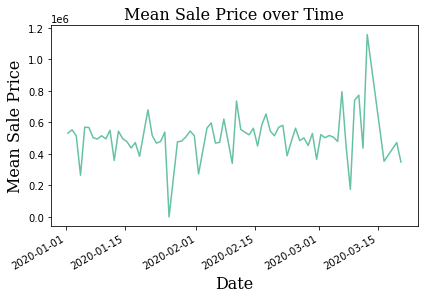

In [41]:
fig, ax = plt.subplots()
ax.plot(mean_per_day, color='#66c2a4')
ax.set_xlabel('Date', **fonts)
ax.set_ylabel('Mean Sale Price', **fonts)
ax.set_title('Mean Sale Price over Time', **fonts)
fig.tight_layout()
fig.autofmt_xdate()
plt.show()

In [72]:
single_family.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1446 entries, 1 to 2247
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Parcel #       1446 non-null   object        
 1   Date of Sale   1446 non-null   datetime64[ns]
 2   Sale Price     1446 non-null   float64       
 3   Lot Size       1446 non-null   float64       
 4   Year Built     1444 non-null   float64       
 5   Type           1446 non-null   object        
 6   Quality/Grade  1446 non-null   object        
 7   Sqft           1443 non-null   float64       
 8   Address        1446 non-null   object        
 9   City           1446 non-null   object        
 10  Nbhd           1446 non-null   object        
 11  Use Code       1446 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(6)
memory usage: 146.9+ KB


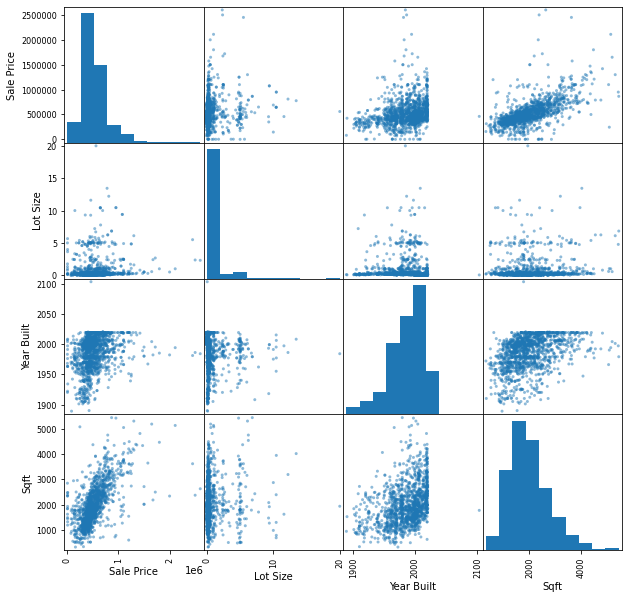

In [75]:
pd.plotting.scatter_matrix(
    single_family[[
        'Date of Sale', 
        'Sale Price',
        'Lot Size',
        'Year Built',
        'Type',
        'Quality/Grade',
        'Sqft',
        'Nbhd'
    ]], figsize=(10,10));